In [1]:
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt

In [45]:
import pandas as pd

df = pd.read_csv("../Datasets/Advertising Budget and Sales.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               200 non-null    int64  
 1   TV Ad Budget ($)         200 non-null    float64
 2   Radio Ad Budget ($)      200 non-null    float64
 3   Newspaper Ad Budget ($)  200 non-null    float64
 4   Sales ($)                200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [46]:
# Drop the first unnamed column
df = df.drop(columns=["Unnamed: 0"])

# Define X (features) and y (target)
X = df.drop(columns=["Sales ($)"])
y = df["Sales ($)"]

In [47]:
X.shape

(200, 3)

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 2)

X_pca = pca.fit_transform(X)
X_pca.shape

(200, 2)

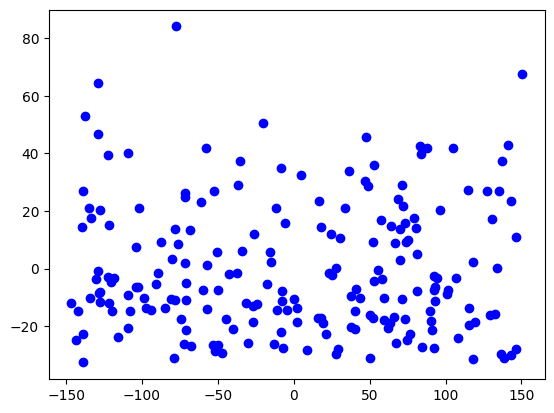

In [44]:
## plotting
plt.plot(X_pca[:, 0], X_pca[:, 1], 'bo')
plt.show()

## 1. K-means

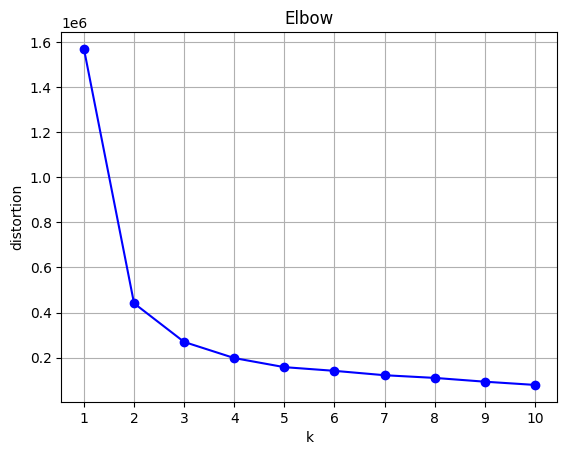

In [11]:
from sklearn.cluster import KMeans

distortion = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters= k,
                    random_state=42)
    
    kmeans.fit(X_pca)
    distortion.append(kmeans.inertia_)
    
    
plt.plot(k_range, distortion, 'bo-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow')
plt.xticks(k_range)
plt.grid(True)
plt.show()

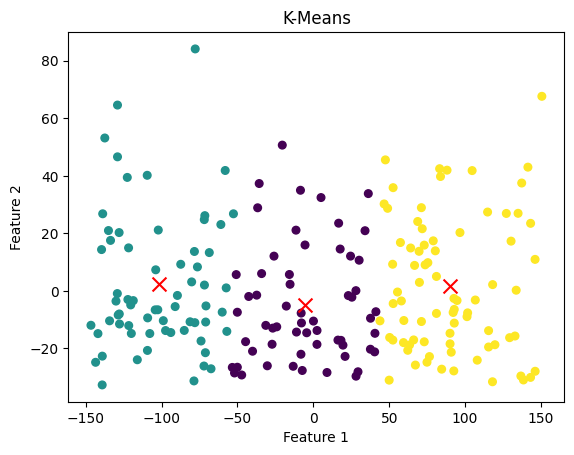

In [12]:
kmeans = KMeans(n_clusters= 3,
                random_state=42)
kmeans.fit(X_pca)

labels_kmeans  = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans , marker='o', s=30, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means")
plt.show()

In [16]:
from sklearn.metrics import silhouette_score

score_kmeans = silhouette_score(X_pca, labels_kmeans)

## 2. Hierarchical

In [14]:
from sklearn.cluster import AgglomerativeClustering

linkage_methods = ['ward', 'complete', 'average', 'single']
total_y_pred = []
score_hier = []

for link in linkage_methods:
    agg_clustering = AgglomerativeClustering(n_clusters=3, 
                                            linkage=link)
    
    y_pred = agg_clustering.fit_predict(X_pca)
    score = silhouette_score(X_pca, y_pred)
    
    total_y_pred.append(y_pred)
    score_hier.append(score)

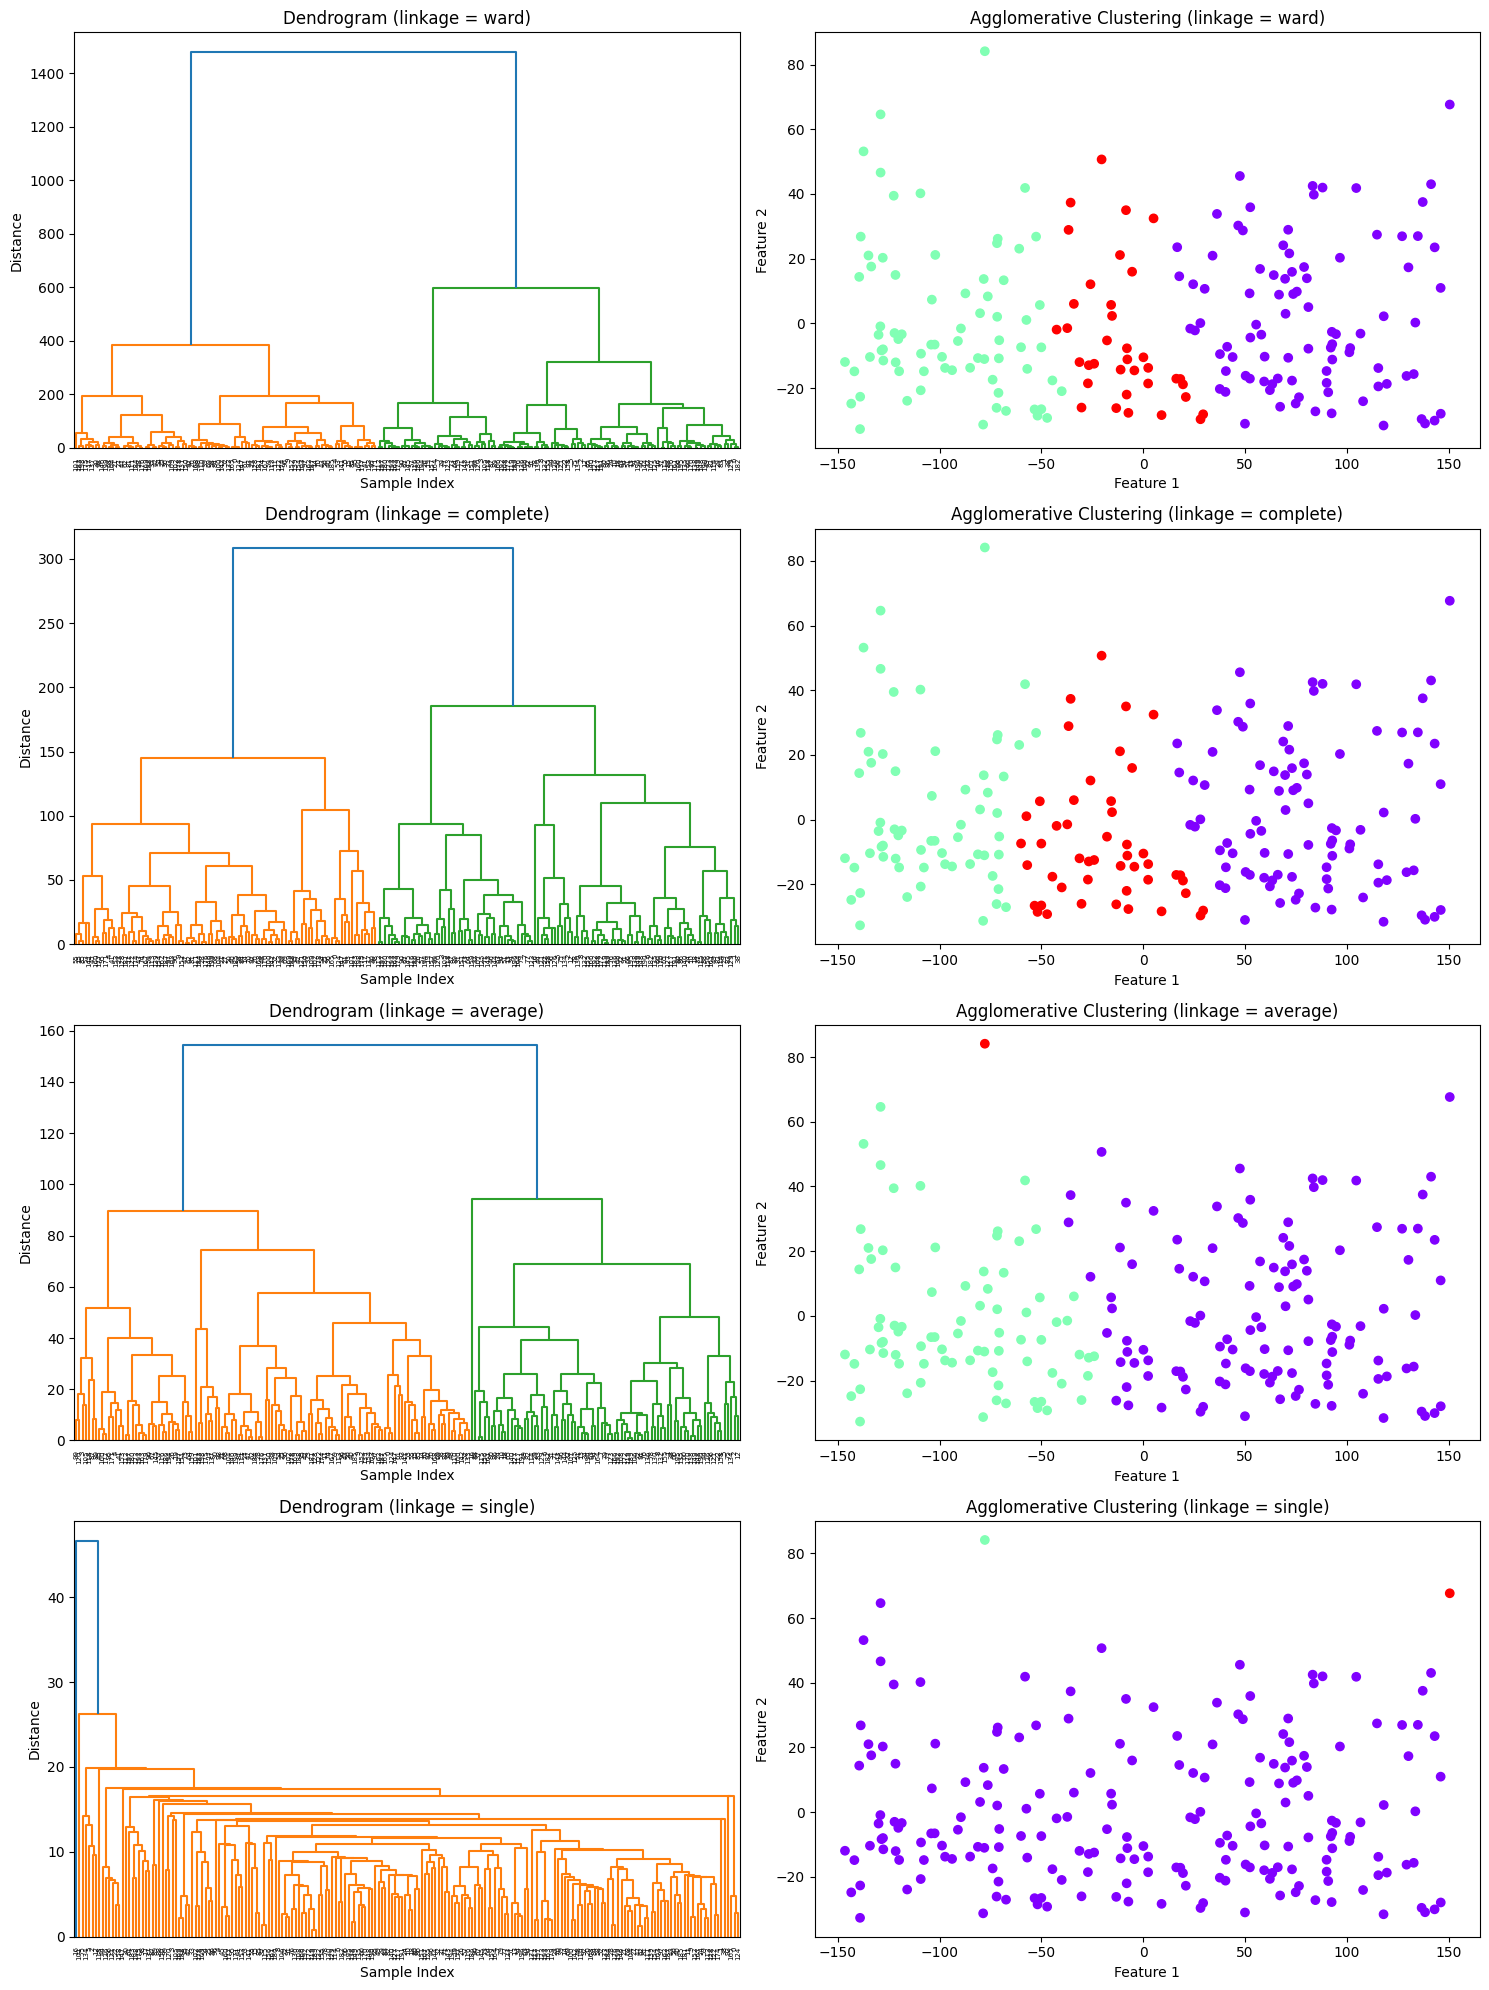

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage

titles = [
    f'Agglomerative Clustering (linkage = {method})' for method in linkage_methods
]

fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for i, method in enumerate(linkage_methods):
    
    # 1. dendogram
    ax_dendro = axes[i, 0] # on the left
    
    Z = linkage(X_pca, method=method)

    dendrogram(Z, ax=ax_dendro)
    ax_dendro.set_title(f'Dendrogram (linkage = {method})')
    ax_dendro.set_xlabel('Sample Index')
    ax_dendro.set_ylabel('Distance')


    # 2. scatter plot
    ax_scatter = axes[i, 1] # on the right
    y_pred = total_y_pred[i] 
    
    ax_scatter.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='rainbow')
    ax_scatter.set_title(titles[i])
    ax_scatter.set_xlabel('Feature 1')
    ax_scatter.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 3. DBSCAN

In [65]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps = 0.8,
            min_samples= 20).fit(X_pca)

In [66]:
from plotnine import *
%matplotlib inline

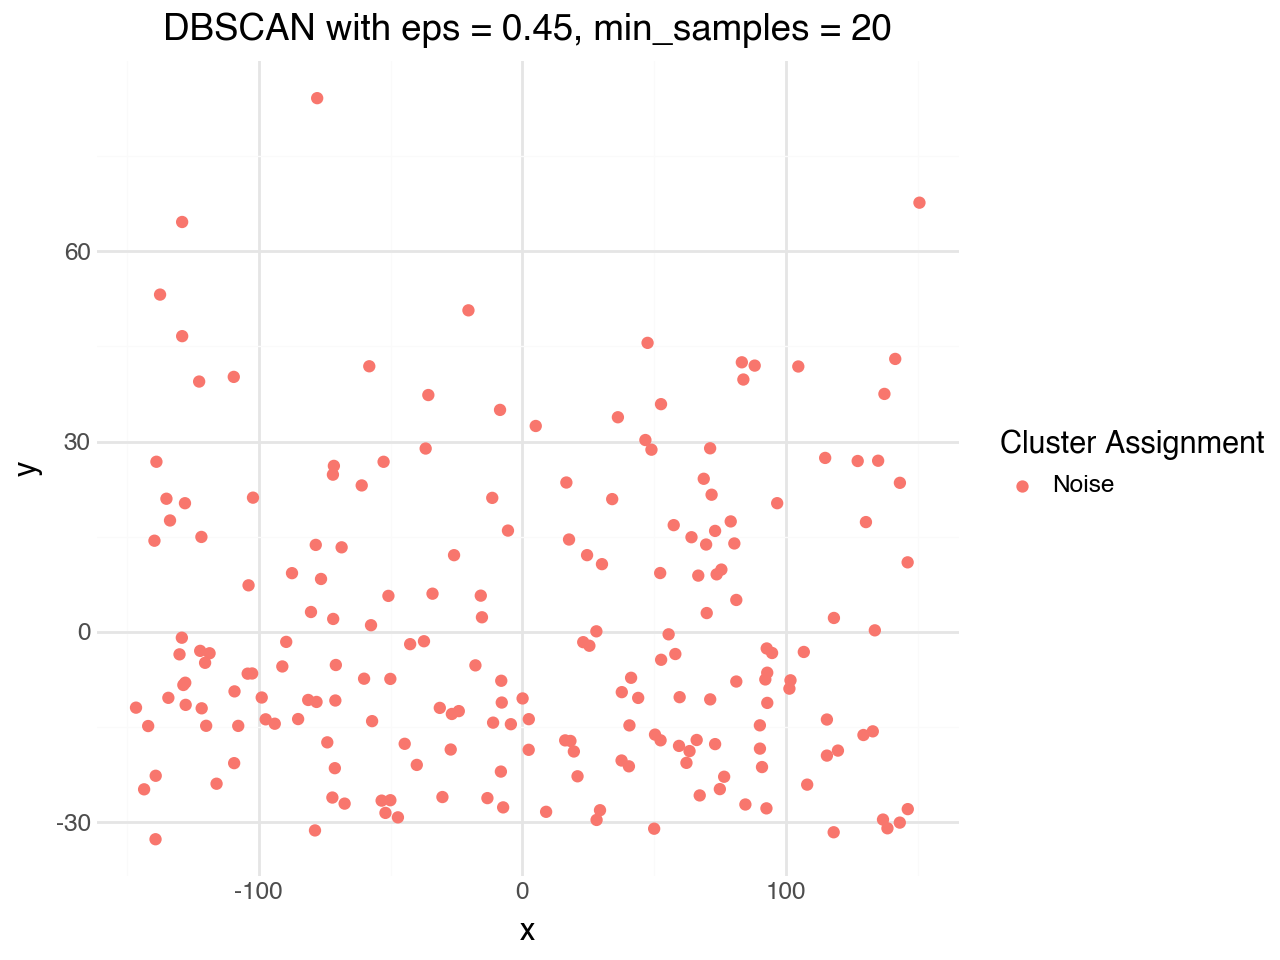

In [67]:
import pandas as pd

# convert X to a pandas df
d = pd.DataFrame(X_pca, columns=["x", "y"])
d["assignments"] = db.labels_


labsList = ["Noise"] + [
    f"Cluster {i}" for i in range(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
]

(ggplot(d, aes(x = "x", y = "y", color = "factor(assignments)")) +
geom_point() +
theme_minimal() +
scale_color_discrete(name = "Cluster Assignment",
                    labels = labsList) +
labs(title = "DBSCAN with eps = 0.45, min_samples = 20"))


In [53]:
# score_db = silhouette_score(X_pca, d["assignments"])

## 4. GMM

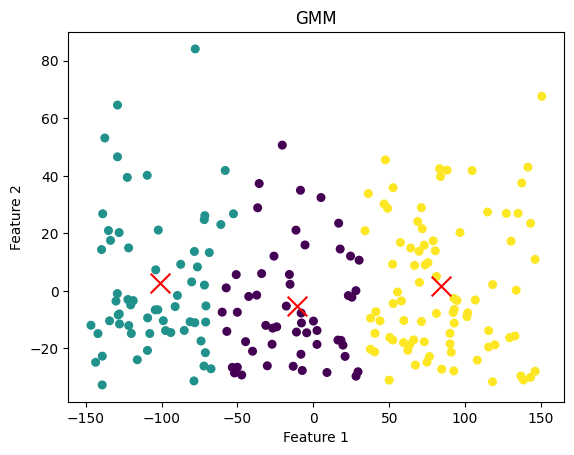

In [54]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3,
                    random_state=42)
gmm.fit(X_pca)

labels_gmm  = gmm.predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm , marker='o', s=30, label='Data points')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c="red", marker="x", s=200, label="Cluster Means")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GMM")
plt.show()

In [32]:
score_gmm = silhouette_score(X, labels_gmm)

## Final scores

In [55]:
print("Silhouette Scores:")
print("-"*50)

print(f"KMeans: {score_kmeans:.3f}")
print("-"*50)

print(*(f"Hierarchical {link}:{score:.3f}\n" for link, score in zip(linkage_methods, score_hier)))
print("-"*50)

# print(f"DBSCAN:{score_db:.3f}")
# print("-"*50)

print(f"GMM:{score_gmm:.3f}")

Silhouette Scores:
--------------------------------------------------
KMeans: 0.474
--------------------------------------------------
Hierarchical ward:0.427
 Hierarchical complete:0.463
 Hierarchical average:0.473
 Hierarchical single:-0.039

--------------------------------------------------
GMM:0.442
